# Classificação Quântica do Dataset Blobs (Baseline)

Este notebook implementa um classificador quântico variacional simples para o dataset Blobs, servindo como **baseline** para comparação com problemas mais complexos como Moons e Iris. Por ser um problema linearmente separável, utilizamos a configuração mínima de circuito.

# Importação das Bibliotecas e definição de parametros


In [1]:
import pennylane as qml
from pennylane import AdamOptimizer
import pennylane.numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
dev = qml.device("default.qubit")

## Configuração do Dispositivo Quântico

## Configuração de Hiperparâmetros

Por ser um dataset linearmente separável, utilizamos a configuração mínima:
- **1 qubit**: Suficiente para classificação binária simples
- **1 camada**: Profundidade mínima do circuito variacional

In [3]:
n_qubits = 1
n_layers = 1
shape_weights = (n_layers, n_qubits, 3)
weights_init =  np.random.randn(n_layers,n_qubits,3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

## Circuito Quântico e Funções

O circuito utiliza um ansatz simples com rotações RY e portas CNOT:
- Não foi necessário um circuito complexo devido à natureza linear do problema
- Utilizamos `AmplitudeEmbedding` para encoding dos dados
- Lemos apenas o qubit 0 para evitar ruído adicional na saída

In [4]:
def layer(weights_da_camada):
    for i in range(n_qubits):
        qml.RY(weights_da_camada[i, 1], wires=i)

    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    for i in range(n_qubits):
        qml.RY(weights_da_camada[i, 1], wires=i)


@qml.qnode(dev)
def circuito(weights, x):
    qml.AmplitudeEmbedding(
        features=x,
        wires=range(n_qubits),
    )

    for layer_w in weights:
        layer(layer_w)

    return qml.expval(qml.PauliZ(0))


Função de Custo (Loss Function)

- Cross-Entropy vs MSE: Embora o Erro Quadrático Médio (MSE) seja comum, a Cross-Entropy (Entropia Cruzada) foi selecionada como padrão para este problema.

- Justificativa: Ela demonstrou uma convergência mais rápida e estável, tratando a saída do circuito quântico de forma mais eficiente.

In [5]:
def cost(weights, bias, X, Y):
    raw_preds = [circuito(weights, x) + bias for x in X]
    predictions = qml.math.stack(raw_preds)

    probs = 1 / (1 + qml.math.exp(-predictions))

    loss = -qml.math.mean(
        Y * qml.math.log(probs + 1e-7)
        + (1 - Y) * qml.math.log(1 - probs + 1e-7)
    )
    return loss


- Implementei uma função de acurácia manual para garantir uma validação direta e transparente dos acertos do modelo em cada época.
- Estratégia de Treinamento: Utilizei o otimizador Adam com uma Learning Rate (taxa de aprendizado) relativamente alta.

- Justificativa: Como a topologia do problema é simples (linear), uma taxa de aprendizado maior permite que o modelo encontre o ponto de convergência rapidamente, sem o risco de instabilidade que ocorreria em problemas mais complexos.

In [6]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

## Definição do Otimizador

Utilizamos Adam com learning rate de 0.01. Uma taxa relativamente alta é apropriada para problemas simples como este.

In [7]:
opt = qml.AdamOptimizer(0.01)

# Dataset
- Criei com sklearn o dataset, relativamente concentrado pois o objetivo maior era aferir os problemas não lineares

In [8]:
from sklearn.datasets import make_blobs
X, y = make_blobs(
    n_samples=500,
    centers=2,
    n_features=2,
    cluster_std=1.4,
    random_state=42
)


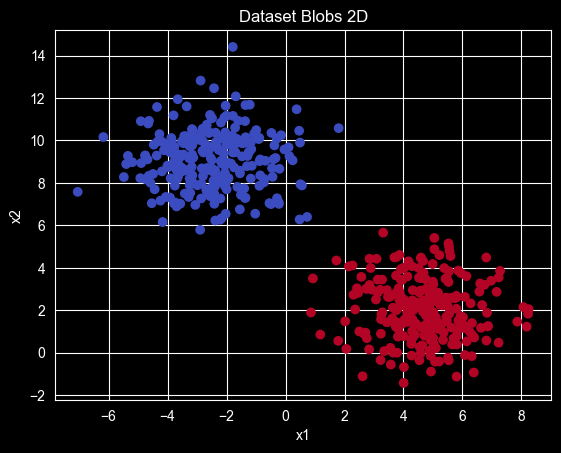

In [9]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset Blobs 2D")
plt.show()


- Precisei normalizar os dados para poder passar no amplitude embedding sem perder a noção de posição dos blobs.
- Além disso, fiz uma separação entre dado de validação e treinamento para execução da seguinte celula

In [10]:
X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
y = y.astype(float)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_norm, y, test_size=0.2, random_state=42
)

# Treinamento
- Aqui é uma "função" de treinamento padrão, utilizei o tqdm para ter uma atualização do loop mais rapidamente.
- Ao fim do codigo se encontra o plot dos graficos de loss e acuracia, são gerados ao fim da execução para poder saber como anda o treinamento
- A validação é feita somente com os dados de validação para avaliar como o modelo ta indo com dados não treinados

In [11]:
def predict_proba(X, weights, bias):
    raw = [circuito(weights, x) + bias for x in X]
    raw = qml.math.stack(raw)
    return 1 / (1 + qml.math.exp(-raw))
def predict(X, weights, bias):
    probs = predict_proba(X, weights, bias)
    return (probs >= 0.5).astype(int)

Treinando: 100%|██████████| 120/120 [00:32<00:00,  3.72it/s, acc=1.0000, loss=0.3501]


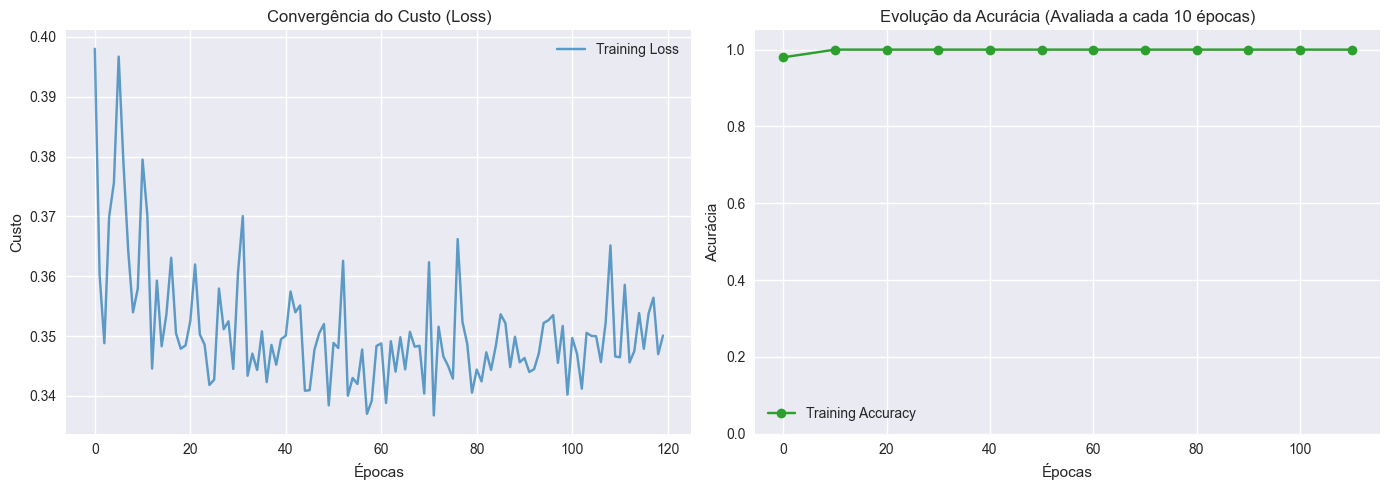

In [12]:
weights = weights_init
bias = bias_init
from tqdm import tqdm
loss_history = []
acc_history = []
epochs_x = []

epochs = 120
batch_size = 80

pbar = tqdm(range(epochs), desc="Treinando")

last_acc = 0.0

for it in pbar:
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = y_train[batch_index]

    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    current_cost = cost(weights, bias, X_batch, Y_batch)
    loss_history.append(float(current_cost))

    if it % 10 == 0:
        predictions = predict(X_val, weights, bias)

        current_acc = accuracy(y_val, predictions)

        acc_history.append(current_acc)
        epochs_x.append(it)

        last_acc = current_acc

    pbar.set_postfix(loss=f"{current_cost:.4f}", acc=f"{last_acc:.4f}")


plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(epochs), loss_history, label='Training Loss', color='tab:blue', alpha=0.7)
ax1.set_title('Convergência do Custo (Loss)')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Custo')
ax1.grid(True)
ax1.legend()

ax2.plot(epochs_x, acc_history, label='Training Accuracy', color='tab:green', marker='o', linestyle='-')
ax2.set_title('Evolução da Acurácia (Avaliada a cada 10 épocas)')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Acurácia')
ax2.set_ylim(0, 1.05) #
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Plot da linha de decisão
Aqui esta a logica de conversão da normalização para coordenadas originais e o plot da linha de decisão do modelo

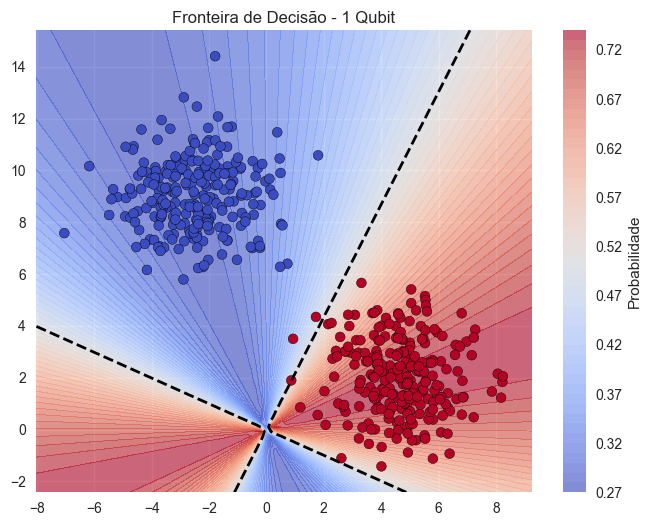

In [13]:
# 1. Definição do Grid (Resolução 100 é o equilíbrio perfeito entre beleza e velocidade)
res = 100
x_vals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, res)
y_vals = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, res)
xx, yy = np.meshgrid(x_vals, y_vals)

# 2. Preparação dos Dados (Vetorizado)
grid_2d = np.c_[xx.ravel(), yy.ravel()]
# Normalização em lote: evita o loop for e calcula tudo de uma vez
norms = np.linalg.norm(grid_2d, axis=1, keepdims=True)
grid_norm = grid_2d / np.where(norms > 1e-10, norms, 1.0)

# 3. Predição e Reshape
# Aqui chamamos o modelo uma única vez para todos os pontos do grid
Z = predict_proba(grid_norm, weights, bias).reshape(xx.shape)

# 4. Plotagem
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.6)
plt.colorbar(label="Probabilidade")
plt.contour(xx, yy, Z, levels=[0.5], colors="black", linewidths=2, linestyles="--") # Linha de decisão
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolors="k", s=50)

plt.title("Fronteira de Decisão - 1 Qubit")
plt.show()